In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix , classification_report
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split , StratifiedKFold , RandomizedSearchCV
from tensorflow.keras.layers import Dense , InputLayer , Dropout , Conv2D , MaxPooling2D , Flatten , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import  relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model , save_model
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/emnist-letters-train.csv')

Mounted at /content/drive


In [7]:
x = train.iloc[:,1:]
y = train.iloc[ : , 0 ]

In [3]:
english_chars = [
    'A/a', 'B/b', 'C/c', 'D/d', 'E/e', 'F/f', 'G/g', 'H/h', 'I/i', 'J/j', 'K/k',
    'L/l', 'M/m', 'N/n', 'O/o', 'P/p', 'Q/q', 'R/r', 'S/s', 'T/t', 'U/u', 'V/v',
    'W/w', 'X/x', 'Y/y', 'Z/z'
]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.15, random_state=42)

In [9]:
x_train.shape , y_train.shape

((75479, 784), (75479,))

In [10]:
x_test.shape , y_test.shape

((13320, 784), (13320,))

Class Distribution in Training Set:
Class 1: 2882 instances
Class 2: 2883 instances
Class 3: 2919 instances
Class 4: 2912 instances
Class 5: 2947 instances
Class 6: 2871 instances
Class 7: 2859 instances
Class 8: 2911 instances
Class 9: 2911 instances
Class 10: 2856 instances
Class 11: 2906 instances
Class 12: 2884 instances
Class 13: 2909 instances
Class 14: 2836 instances
Class 15: 2900 instances
Class 16: 2910 instances
Class 17: 2923 instances
Class 18: 2894 instances
Class 19: 2891 instances
Class 20: 2944 instances
Class 21: 2934 instances
Class 22: 2915 instances
Class 23: 2897 instances
Class 24: 2929 instances
Class 25: 2946 instances
Class 26: 2910 instances


<ipython-input-11-7d10874b7f8f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Reds_d")


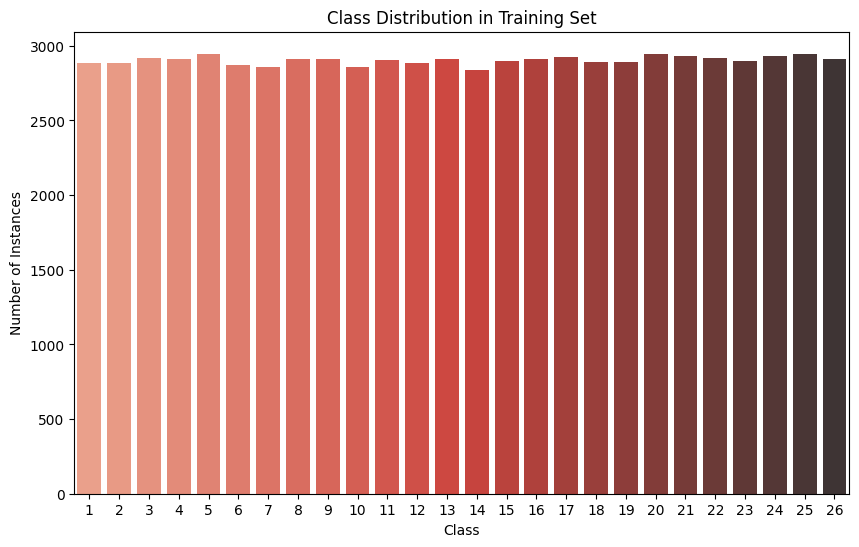

In [11]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution in Training Set:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} instances")

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()), palette="Reds_d")
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Training Set')
plt.show()

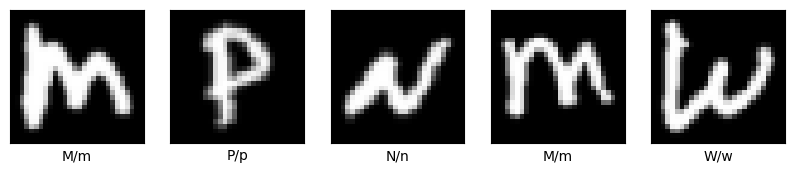

In [12]:
ra = np.random.choice(x_train.index, size=5, replace=False)

plt.figure(figsize=(10, 2))
for i in range(len(ra)):
    plt.subplot(1, len(ra), i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train.loc[ra[i]].values.reshape(28, 28).T, cmap='gray')
    plt.xlabel(english_chars[y_train.loc[ra[i]] - 1], fontsize=10, color='black', ha='center')
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [14]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [15]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [16]:
x_train.shape , x_test.shape

((75479, 28, 28, 1), (13320, 28, 28, 1))

In [33]:
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Dropout(0.5),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(26, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 13, 13, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 467,546 (1.78 MB)

 Trainable params: 464,666 (1.77 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [18]:
model_checkpoint_callback = ModelCheckpoint(
    filepath="best.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [19]:
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [20]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/25
1179/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5806 - loss: 1.4529
Epoch 1: val_accuracy improved from -inf to 0.86584, saving model to best.keras
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 107s 83ms/step - accuracy: 0.5809 - loss: 1.4519 - val_accuracy: 0.8658 - val_loss: 0.4187
Epoch 2/25
1179/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8520 - loss: 0.4614
Epoch 2: val_accuracy improved from 0.86584 to 0.90368, saving model to best.keras
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 138s 80ms/step - accuracy: 0.8520 - loss: 0.4614 - val_accuracy: 0.9037 - val_loss: 0.3035
Epoch 3/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8789 - loss: 0.3678
Epoch 3: val_accuracy improved from 0.90368 to 0.90938, saving model to best.keras
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.8789 - loss: 0.3678 - val_accuracy: 0.9094 - val_loss: 0.2659
Epoch 4/25
1179/1180 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8935 - loss: 0.3282
Epoch 4: val_accuracy did not im

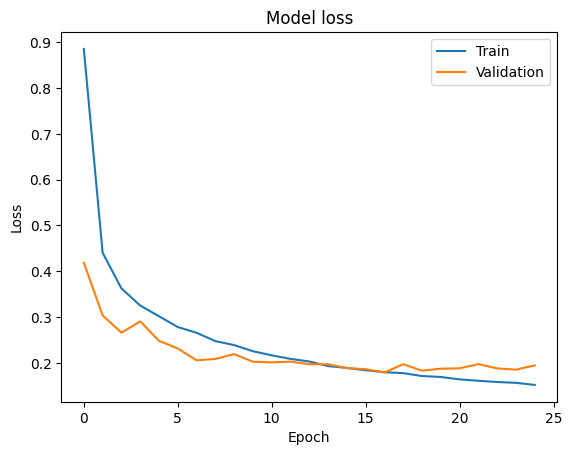

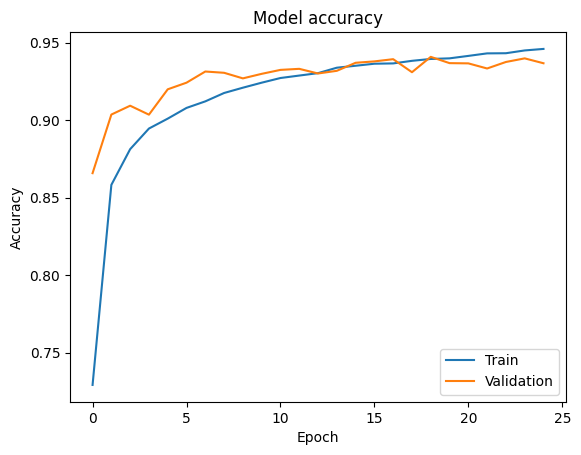

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [22]:
x_test_reshaped = x_test.reshape(-1, 28, 28, 1)

pred = model.predict(x_test_reshaped)

417/417 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


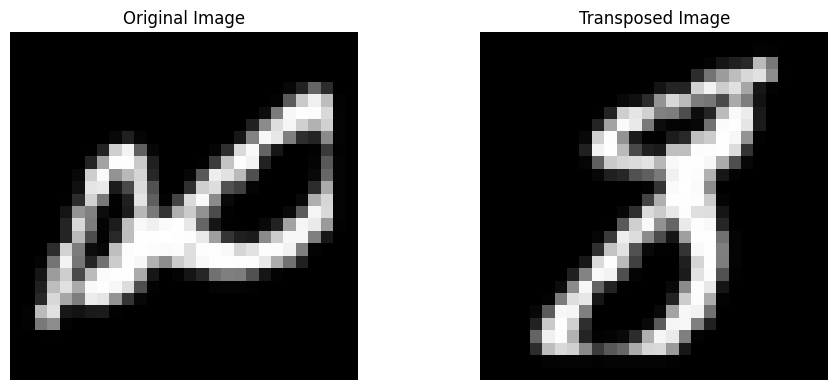

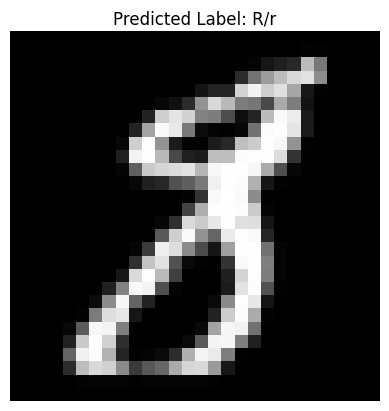

In [32]:
predicted_label = english_chars[np.argmax(pred[10])]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(x_test[10].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(x_test[10].reshape(28, 28).T, cmap='gray')
plt.axis('off')
plt.title('Transposed Image')

plt.tight_layout()
plt.show()

plt.imshow(x_test[10].reshape(28, 28).T, cmap='gray')
plt.title(f'Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()

417/417 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step


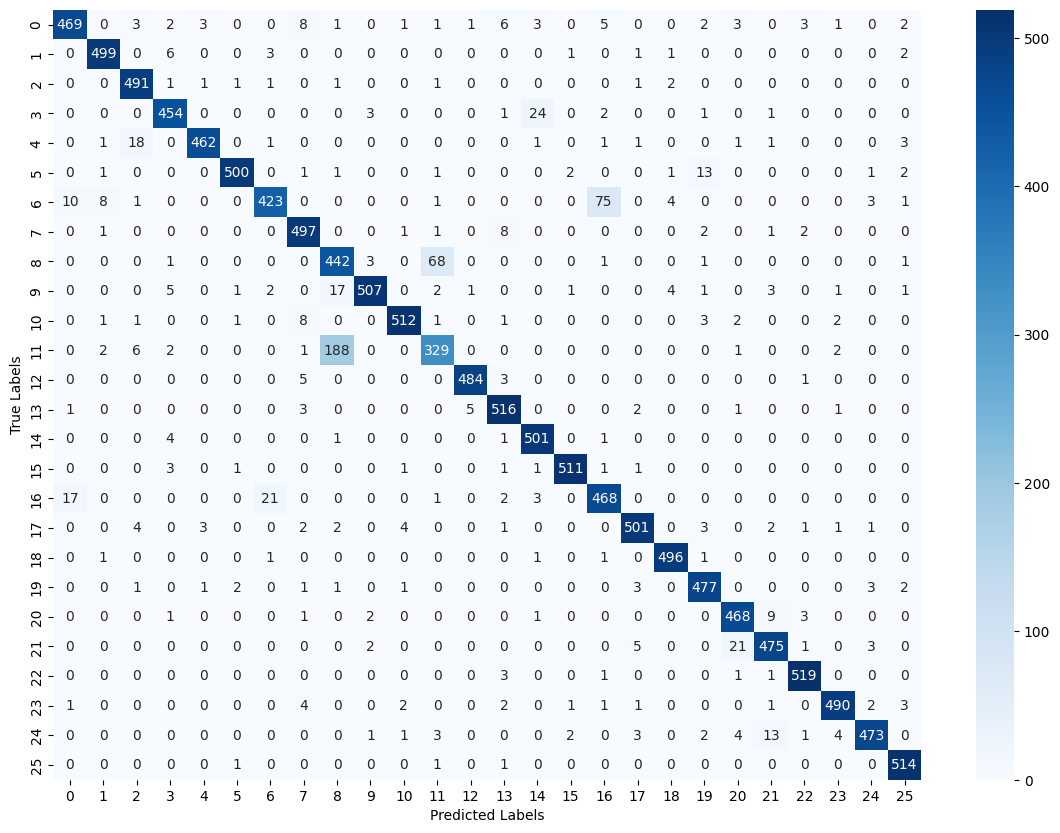

In [25]:
y_preds = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_preds, axis=1)

# Since y_test is already in label form, no need to apply np.argmax
y_true = y_test

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix as a heat map
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [26]:
cr = classification_report(y_true, y_pred_classes)
print(cr)

              precision    recall  f1-score   support

           1       0.94      0.91      0.93       514
           2       0.97      0.97      0.97       513
           3       0.94      0.98      0.96       500
           4       0.95      0.93      0.94       486
           5       0.98      0.94      0.96       490
           6       0.99      0.96      0.97       523
           7       0.94      0.80      0.87       526
           8       0.94      0.97      0.95       513
           9       0.68      0.85      0.75       517
          10       0.98      0.93      0.95       546
          11       0.98      0.96      0.97       532
          12       0.80      0.62      0.70       531
          13       0.99      0.98      0.98       493
          14       0.95      0.98      0.96       529
          15       0.94      0.99      0.96       508
          16       0.99      0.98      0.98       520
          17       0.84      0.91      0.88       512
          18       0.97    

In [28]:
model.save('/content/drive/My Drive/en_char_final.h5')